# Train a shallow SNN on the Randman Dataset

In [1]:
import sys
sys.path.append("../../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

import wandb

In [2]:
# Dataset parameters
hyperparameter_defaults = {
    "dim_manifold":1,
    "nb_classes":10,
    "nb_inputs":20,
    "nb_time_steps":100,
    "step_frac":0.5,
    "nb_samples":1000,
    "nb_spikes":1,
    "alpha":1,
    "randmanseed":1,
    "dt":2e-3,
}
duration = hyperparameter_defaults["nb_time_steps"]*hyperparameter_defaults["dt"]

# Network parameter
hyperparameter_defaults.update({
    "duration": duration,
    "batch_size": 250,
    "beta": 100,
    "nb_hidden_units": 64,
    "tau_mem": 20e-3,
    "tau_syn": 10e-3,
    "tau_readout": duration,
    "lr": 0.5,
    "nb_epochs": 50,
    "mu_u": 0,
    "xi": 1,
    "spike_type": "MultilayerSpikerSpike",
    "eps_0": 0.267,
    "p0": 0.01,
    "delta_u": 0.133
})

In [3]:
wandbrun = wandb.init(
    project="stork-test",
    entity="jgygax",
    config=hyperparameter_defaults,
    # mode="disabled"
    )

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jgygax. Use `wandb login --relogin` to force relogin


## Generate Dataset

Specify the Dataset Parameters

In [4]:
data, labels = stork.datasets.make_tempo_randman(
    dim_manifold=config["dim_manifold"],
    nb_classes=config["nb_classes"],
    nb_units=config["nb_inputs"],
    nb_steps=config["nb_time_steps"],
    step_frac=config["step_frac"],
    nb_samples=config["nb_samples"],
    nb_spikes=config["nb_spikes"],
    alpha=config["alpha"],
    seed=config["randmanseed"])

ds_kwargs = dict(
    nb_steps=config["nb_time_steps"],
    nb_units=config["nb_inputs"],
    time_scale=1.0
)

# Split into train, test and validation set
datasets = [stork.datasets.RasDataset(ds, **ds_kwargs) for ds in
            stork.datasets.split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)]
ds_train, ds_valid, ds_test = datasets

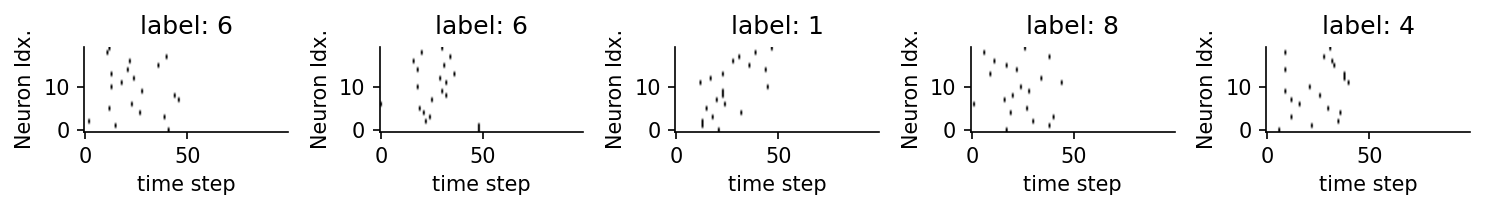

In [5]:
fig, ax = plt.subplots(1,5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()


## Set up the model

In [6]:
# Model Parameters
device = torch.device("cpu")
dtype = torch.float

In [7]:
act_fn = stork.activations.SuperSpike
act_fn.beta = config["beta"]
neuron_group = LIFGroup

model = RecurrentSpikingModel(
    config["batch_size"],
    config["nb_time_steps"],
    config["nb_inputs"],
    device,
    dtype)

Add neuron groups

In [8]:
input_group = model.add_group(InputGroup(config["nb_inputs"]))
hidden_neurons = model.add_group(LIFGroup(
    config["nb_hidden_units"],
    tau_mem=config["tau_mem"],
    tau_syn=config["tau_syn"],
    activation=act_fn))
readout_group = model.add_group(ReadoutGroup(
    config["nb_classes"],
    tau_mem=config["tau_readout"],
    tau_syn=config["tau_syn"],
    initial_state=-1e-2))



Add synapses between the neuron groups

In [9]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [10]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = 4       # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [11]:
sigma_u = 1.0
nu = config["nb_spikes"]/duration

initializer = FluctuationDrivenCenteredNormalInitializer(sigma_u=1.0, nu=nu, timestep=config["dt"])

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [12]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [13]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [14]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [15]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=config["lr"]),
                time_step=config["dt"], 
                wandb=wandbrun)

Before we train the model, we monitor the spikes

In [16]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq_init"] = [nb/len(ds_test)/duration/config["nb_hidden_units"] for nb in total_spikes_per_layer]

for i, r in enumerate(results["avg_layer_freq_init"]):
    wandbrun.log({"avg_layer_freq_init_"+str(i): r})

print(results)

{'avg_layer_freq_init': [5.92796875]}


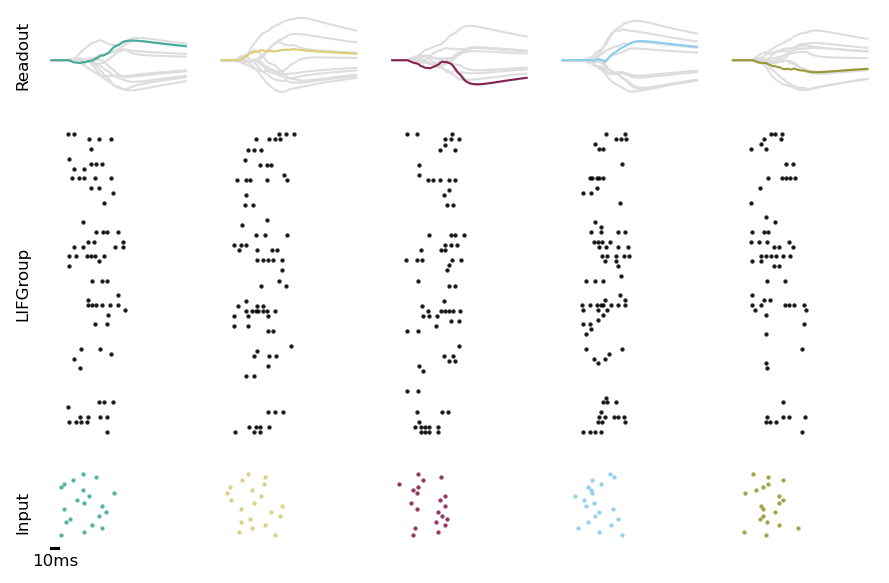

In [17]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False)

## Training

takes around 13-20 minutes

In [18]:
history = model.fit_validate(
    ds_train,
    ds_valid,
    nb_epochs=config["nb_epochs"],
    verbose=False)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


#### Monitor the model again after training

In [19]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq"] = [nb/len(ds_test)/duration/config["nb_hidden_units"] for nb in total_spikes_per_layer]

for i, r in enumerate(results["avg_layer_freq"]):
    wandbrun.log({"avg_layer_freq_"+str(i): r})


## Test

In [20]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

wandbrun.log({
    "test_loss": results["test_loss"],
    "test_acc": results["test_acc"]
})

Test loss:  0.4600050300359726
Test acc.:  86.1 %


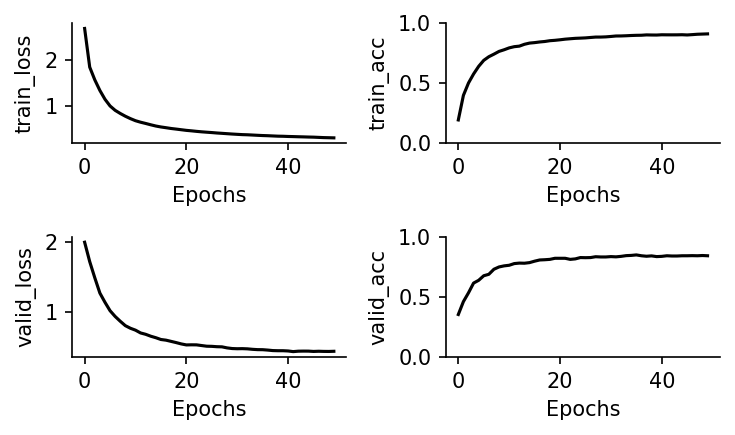

In [21]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"]*100, 2), "%")

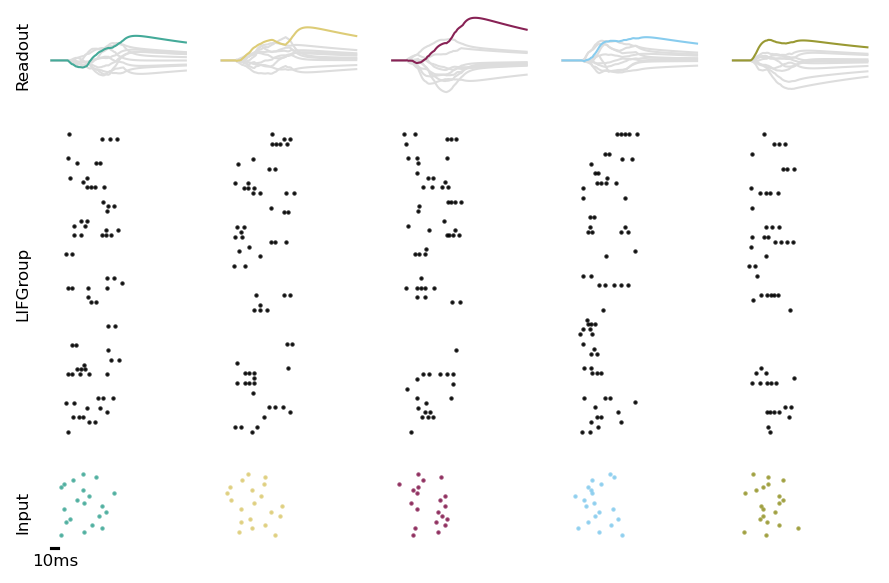

wandb: Network error (ConnectionError), entering retry loop.


In [22]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False,
    nb_samples=5)